# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [246]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [247]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [248]:
def Q1(num_examples=5):
    ### STUDENT START ###
    
    # iterate through the number of examples
    for i in range(num_examples):
        # prints label
        print("LABEL:",newsgroups_train.target_names[train_labels[i]])
        # prints text
        print("TEXT:\n", train_data[i], sep='')
        # prints a line to separate each example for better viewing
        print("------")
        
    ### STUDENT END ###

Q1(5)

LABEL: comp.graphics
TEXT:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
------
LABEL: talk.religion.misc
TEXT:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centur

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [249]:
def Q2():
    ### STUDENT START ###
    
    # part 1
    print("--- Part 1 ---")
    # initialize and fit train data to countvectorizer
    cvec = CountVectorizer()
    fit_cvec = cvec.fit_transform(train_data)
    # A. Size of the vocabulary
    print("Size of Vocabulary:", fit_cvec.shape[1])
    # B. average number of non-zero features per example
    avgnnz = 0
    for i in range(len(train_data)):
        avgnnz += fit_cvec[i].nnz
    avgnnz = avgnnz/len(train_data)
    print("Average number of nnz per example:", avgnnz)
    # C. fraction of the non-zero entries in the matrix
    frac = fit_cvec.nnz / (fit_cvec.shape[0]*fit_cvec.shape[1])
    print("Fraction of nnz in matrix:", frac)
    # D. 0th and last feature strings (in alphabetical order)
    feat_str = cvec.get_feature_names()
    print("0th feature string:", feat_str[0])
    print("Last feature string:", feat_str[-1])
    
    # part 2
    print("\n--- Part 2 ---")
    # initialize and fit data to countvectorizer
    vocab_cvec = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"])
    fit_vocab_cvec = vocab_cvec.transform(train_data)
    # Size of the vocabulary
    print("Size of Vocabulary (with Defined Sets):", fit_vocab_cvec.shape[1])
    # average number of non-zero features per example
    avgnnzset = 0
    for i in range(len(train_data)):
        avgnnzset += fit_vocab_cvec[i].nnz
    avgnnzset = avgnnzset/len(train_data)
    print("Average number of nnz per example:", avgnnzset)
    
    # part 3
    print("\n--- Part 3 ---")
    # initialize and fit data to countvectorizer
    ngram_cvec = CountVectorizer(analyzer='char', ngram_range=(2,3))
    fit_ngram_cvec = ngram_cvec.fit_transform(train_data)
    # size of the vocabulary
    print("Size of Vocabulary (of bigram and trigram feature vectors):", fit_ngram_cvec.shape[1])

    # part 4
    print("\n--- Part 4 ---")
    # initialize and fit data to countvectorizer
    prune_cvec = CountVectorizer(min_df=10)
    fit_prune_cvec = prune_cvec.fit_transform(train_data)
    # size of the vocabulary
    print("Size of Vocabulary (with pruned words):", fit_prune_cvec.shape[1])
    
    # part 5
    print("\n--- Part 5 ---")
    # initialize and fit dev data to countvectorizer
    cvec_dev = CountVectorizer()
    dev_fit_cvec = cvec_dev.fit_transform(dev_data)
    # words in the development vocabulary that is missing from the training vocabulary
    cvec_diff = len(set(cvec_dev.get_feature_names()) - set(cvec.get_feature_names()))
    # fraction of these words in dev vocab and not in train vocab
    print("Fraction of Dev Vocab not in Train Vocab:", cvec_diff / dev_fit_cvec.shape[1])
    
    ### STUDENT END ###

Q2()

--- Part 1 ---
Size of Vocabulary: 26879
Average number of nnz per example: 96.70599803343165
Fraction of nnz in matrix: 0.0035978272269590263
0th feature string: 00
Last feature string: zyxel

--- Part 2 ---
Size of Vocabulary (with Defined Sets): 4
Average number of nnz per example: 0.26843657817109146

--- Part 3 ---
Size of Vocabulary (of bigram and trigram feature vectors): 35478

--- Part 4 ---
Size of Vocabulary (with pruned words): 3064

--- Part 5 ---
Fraction of Dev Vocab not in Train Vocab: 0.24787640034470024


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [251]:
# There was a couple "FutureWarning" so just for better viewing, I imported to ignore the warnings
import warnings
warnings.filterwarnings('ignore')

def Q3():
    ### STUDENT START ###
    
    # train and dev data to matricies
    cvec = CountVectorizer()
    cvec_train = cvec.fit_transform(train_data)
    cvec_dev = cvec.transform(dev_data)
    
    # k-nearest neighbors
    print("--- k-Nearest Neighbors ---")
    # find k that optimizes f1 - found that k=112 is the best to optimize f1
#     diff_k = range(1,200) # tried different k values from 1 to 199
#     temp = (0,0)
    diff_k = [1,20,50,100,112,150]
    for k in diff_k:
        # initialize, fit,and predict for model
        knn = KNeighborsClassifier(k)
        knn.fit(cvec_train, train_labels)
        dev_pred = knn.predict(cvec_dev)
        # find f1 value
        f1val = metrics.f1_score(dev_labels, dev_pred, average="weighted")
#         if f1val > temp[1]: # updates temp variable to find the best k for f1
#             temp = (k, f1val)
#     print(temp)
        print("K-Value =", k)
        print("F1 Value =", f1val)
    
    # naive bayes
    print("\n--- Naive Bayes ---")
    # find alpha that optimizes f1 - found that alpha=0.27 is the best to optimize f1
#     diff_alpha = np.arange(0,1,0.01)
#     temp = (0,0)
    diff_alpha = [0.01, 0.1, 0.2, 0.27, 0.5, 0.9]
    for alpha in diff_alpha:
        # initialize, fit,and predict for model
        nb = MultinomialNB(alpha)
        nb.fit(cvec_train, train_labels)
        dev_pred = nb.predict(cvec_dev)
        # find f1 value
        f1val = metrics.f1_score(dev_labels, dev_pred, average="weighted")
#         if f1val > temp[1]: # updates temp variable to find the best alpha for f1
#             temp = (alpha, f1val)
#     print(temp)
        print("Alpha-Value =", alpha)
        print("F1 Value =", f1val)

    # logistic regression
    print("\n--- Logistic Regression ---")
    # find c that optimizes f1 - found that c=0.55 is the best to optimize f1
#     diff_c = np.arange(0.01,1,0.01)
#     temp = (0,0)
    #for viewing topic order when printing the sum of squared weights list
    print("Topic Order for Sum of Squared Weights:", newsgroups_train.target_names) 
    diff_c = [0.01, 0.2, 0.5, 0.55, 0.7, 0.9]
    for c in diff_c:
        # initialize, fit,and predict for model
        lr = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
        lr.fit(cvec_train, train_labels)
        dev_pred = lr.predict(cvec_dev)
        # find f1 value
        f1val = metrics.f1_score(dev_labels, dev_pred, average="weighted")
    #     if f1val > temp[1]: # updates temp variable to find the best c for f1
    #         temp = (c, f1val)
    # print(temp)
        print("C-Value =", c)
        print("F1 Value =", f1val)
        print("Sum of Squared Weights = ", np.square(lr.coef_).sum(axis=1))

    ### STUDENT END ###

Q3()

--- k-Nearest Neighbors ---
K-Value = 1
F1 Value = 0.3805030018531525
K-Value = 20
F1 Value = 0.4243419588207676
K-Value = 50
F1 Value = 0.4176318433511905
K-Value = 100
F1 Value = 0.4422400339224965
K-Value = 112
F1 Value = 0.47888286605269925
K-Value = 150
F1 Value = 0.4220000000246994

--- Naive Bayes ---
Alpha-Value = 0.01
F1 Value = 0.7751663218544357
Alpha-Value = 0.1
F1 Value = 0.7903052385098862
Alpha-Value = 0.2
F1 Value = 0.7876298330892171
Alpha-Value = 0.27
F1 Value = 0.7918868148009902
Alpha-Value = 0.5
F1 Value = 0.7862862961995258
Alpha-Value = 0.9
F1 Value = 0.7810859843567709

--- Logistic Regression ---
Topic Order for Sum of Squared Weights: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
C-Value = 0.01
F1 Value = 0.6646997417582748
Sum of Squared Weights =  [2.5415166  2.93970937 2.86246894 2.25002873]
C-Value = 0.2
F1 Value = 0.7058733693981117
Sum of Squared Weights =  [49.74190405 42.74215058 49.32509662 42.68967791]
C-Value = 0.5
F1 Value = 0

ANSWER: 

**Why doesn't k-Nearest Neighbors work well for this problem?**
k-Nearest Neighbors does not work well for this problem because with k-nearest neighbors, we want to be working with more unique data points than non-unique data points. In our dataset however, we see alot of overlap with words so finding a k value that gives predictions of neighbors and distances would be difficult and inaccurate.

**Why doesn't Logistic Regression work as well as Naive Bayes does?**
Though logistic regression does better than k-nearest neighbors, naive bayes still is the better model here than logistic regression. One reason could be that since there is a correlation of words with context, naive bayes better fits this bias compared to the linear component of logistic regression. Also, referring back that there is a lot of overlap with words, we can infer that there is a lot of noise that makes it harder to use logistic regression.

**What is the relationship between logistic regression's sum of squared weights vs. C value?**
From what's printed above with the variety of C values and it's corresponding sum of squared weights, we can see a mutual relationship where when C increases, the sums of squared weights for each topic also increases. 

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [252]:
def Q4():
    ### STUDENT START ###
    
    # initialize and fit data to countvectorizer
    cvec = CountVectorizer(ngram_range=(2,2))
    fit_cvec = cvec.fit_transform(train_data)
    # make logistic regression model and fit
    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(fit_cvec, train_labels)
    # find the 5 features with the largest weights
    ind_large = np.argsort(lr.coef_)[:,-5:]
    # append word and weights to dictionary
    bigram_data = {'word': [newsgroups_train.target_names[0], newsgroups_train.target_names[1], newsgroups_train.target_names[2], newsgroups_train.target_names[3]]}
    for item in ind_large:
        for ind in item:
            bigram_data[cvec.get_feature_names()[ind]] = lr.coef_[:,ind]
    # print dictionary in a table format
    for key, value in bigram_data.items():
        atheism, graphics, space, religion = value
        print("{:<20} {:<20} {:<20} {:<20} {:<20}".format(key, atheism, graphics, space, religion))
    
    ### STUDENT END ###

Q4()

word                 alt.atheism          comp.graphics        sci.space            talk.religion.misc  
are you              0.44695392171583426  -0.2482526165223367  -0.09712442878254904 -0.30562181780216796
you are              0.4727409458612008   -0.27990164296203024 -0.48128149655477664 0.028373274576667572
was just             0.48205043350230936  -0.13142214344059297 -0.1289230814593411  -0.2274672469519437 
cheers kent          0.5557193800599775   -0.6979125750878664  -0.6637533543532393  0.5348093334790246  
claim that           0.6055484229735599   -0.1990400363068805  -0.2743406120617598  -0.14036454040470567
is there             -0.3408817642355365  0.7549800082849965   -0.468214235339031   -0.2570800312021349 
out there            -0.2748022518746375  0.7586760823358325   -0.4790865775023061  -0.27708733473309105
comp graphics        -0.29216542126071604 0.8012040263109408   -0.3709337510489662  -0.28518613624023637
in advance           -0.45935081177234927 0.83256992063

ANSWER: 

First, I found that we did have an overlapping word bigram of "cheers kent" and we can see the weights are higher for comp.graphics and talk.religion.misc. Other than that, for it was not surprising to see a higher weight for the topic where the word was taken from, but it was a bit surprising to see the super low numbers (almost all in the negatives) for the weights of that word in other topics. However, looking at the word and its relevence to other topics does make sense why the weights would be lower. For example, using "the space" would clearly be more fitting in the sci.space topic and thus have a high weight whereas this bigram would not be used much in other topic contexts, thus lower weights.

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [253]:
def Q5():
    ### STUDENT START ###

    # function so no preprocessing
    def no_preprocessor(word):
        return word

    # initialize and fit data to countvectorizer
    cvec = CountVectorizer(preprocessor=no_preprocessor)
    cvec_train = cvec.fit_transform(train_data)
    cvec_dev = cvec.transform(dev_data)
    # make logistic regression model and fit
    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(cvec_train, train_labels)
    # find and print f1 value and size of vocabulary 
    dev_pred = lr.predict(cvec_dev)
    f1val = metrics.f1_score(dev_labels, dev_pred, average="weighted")
    print("F1 Value (no preprocessing) =", f1val)
    print("Size of Vocabulary (no preprocessing):", cvec_train.shape[1])
    
    # make a custom-defined function to preprocess strings
    def word_preprocessor(word):
        # lowercase all the words in the dataset
        word = word.lower()
        # makes any non-letter or non-integer character a space
        word = re.sub("[^A-Za-z0-9]", " ", word)
        # delete stop words
        word = ' '.join([item for item in word.split(" ") if item not in ENGLISH_STOP_WORDS])
        # stemming
        ps = nltk.stem.PorterStemmer()
        word = ' '.join([ps.stem(item) for item in word.split(" ")])
        return word
    
    # initialize and fit data to countvectorizer
    cvec = CountVectorizer(preprocessor=word_preprocessor)
    cvec_train = cvec.fit_transform(train_data)
    cvec_dev = cvec.transform(dev_data)
    # make logistic regression model and fit
    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(cvec_train, train_labels)
    # find and print f1 value and size of vocabulary 
    dev_pred = lr.predict(cvec_dev)
    f1val = metrics.f1_score(dev_labels, dev_pred, average="weighted")
    print("F1 Value (post-preprocessing) =", f1val)
    print("Size of Vocabulary (post-preprocessing):", cvec_train.shape[1])
    
    ### STUDENT END ###

Q5()

F1 Value (no preprocessing) = 0.7069109185493502
Size of Vocabulary (no preprocessing): 33291
F1 Value (post-preprocessing) = 0.7270664940028811
Size of Vocabulary (post-preprocessing): 19041


ANSWER:

The improved model of lowercasing all words and replacing non-letter and non-integer characters with a space reduced the vocabulary size by 14,250 words and increased the f1 score by a little over 0.02.

### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

L1 Regularization Strength: 0.01
Vocabulary Size: 17
F1 Value: 0.4678284761184072
L1 Regularization Strength: 0.05
Vocabulary Size: 125
F1 Value: 0.6388542879384481
L1 Regularization Strength: 0.1
Vocabulary Size: 211
F1 Value: 0.687596929187609
L1 Regularization Strength: 0.2
Vocabulary Size: 383
F1 Value: 0.6710619036387335
L1 Regularization Strength: 0.5
Vocabulary Size: 752
F1 Value: 0.6632429175454114
L1 Regularization Strength: 1
Vocabulary Size: 1125
F1 Value: 0.6741770022202319
L1 Regularization Strength: 1.5
Vocabulary Size: 1444
F1 Value: 0.6962094636949021
L1 Regularization Strength: 2
Vocabulary Size: 1746
F1 Value: 0.6832810164436162
L1 Regularization Strength: 5
Vocabulary Size: 2690
F1 Value: 0.7008748677314268


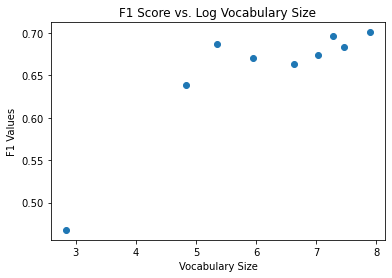

In [254]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###

    # initialize and fit data to countvectorizer
    cvec = CountVectorizer()
    cvec_train = cvec.fit_transform(train_data)
    cvec_dev = cvec.transform(dev_data)
    
    # list of f1 scores and vocabulary sizes for plotting
    f1 = []
    vocab_size = []
    
    # different L1 regularization strengths
#     diff_c = np.arange(0.01,1,0.01)
    diff_c = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 1.5, 2, 5]
    for c in diff_c:
        # initialize, fit,and predict for model
        lrl1 = LogisticRegression(C=c, solver="liblinear", penalty="l1", tol=0.015)
        lrl1.fit(cvec_train, train_labels)
        # check for non-zero weights
        lr_nonzero = np.any(lrl1.coef_ != 0, axis=0)
        # Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
        new_vocab = np.array(cvec.get_feature_names())[lr_nonzero]
        # append this size to the list
        vocab_size.append(len(new_vocab))
        
        # re-initialize and fit new vocabulary to countvectorizer
        cvec_temp = CountVectorizer(vocabulary=new_vocab)
        cvec_temp_train = cvec_temp.transform(train_data)
        cvec_temp_dev = cvec_temp.transform(dev_data)
        
        # initialize, fit,and predict for model L2
        lrl2 = LogisticRegression(C=0.5, solver="liblinear", penalty="l2", tol=0.015)
        lrl2.fit(cvec_temp_train, train_labels)
        # find f1 value and append to list
        dev_pred = lrl2.predict(cvec_temp_dev)
        f1val = metrics.f1_score(dev_labels, dev_pred, average="weighted")
        # append this f1 value to the list
        f1.append(f1val)
        
        # print L1 regularization strength, vocabulary size, and f1 score associated with the new model
        print("L1 Regularization Strength:", c)
        print("Vocabulary Size:", len(new_vocab))
        print("F1 Value:", f1val)
        
    # plot of f1 score vs. log vocabulary size
    plt.scatter(np.log(vocab_size), f1)
    plt.title("F1 Score vs. Log Vocabulary Size")
    plt.ylabel("F1 Values")
    plt.xlabel("Vocabulary Size")
    
    ### STUDENT END ###

Q6()

ANSWER: 

It is very clear that the models perform much better when the full vocabulary is available. We see the huge increase for F1 Value the bigger the vocabulary size.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [255]:
def Q7():
    ### STUDENT START ###

    # initialize and fit new vocabulary to tf-idf 
    tfidf = TfidfVectorizer()
    tfidf_train = tfidf.fit_transform(train_data)
    tfidf_dev = tfidf.transform(dev_data)
    
    # initialize and fit logistic regression model
    lr = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lr.fit(tfidf_train, train_labels)
    # print f1 value
    dev_pred = lr.predict(tfidf_dev)
    f1val = metrics.f1_score(dev_labels, dev_pred, average="weighted")
    print("F1 Score:", f1val)
    
    # find the predicted probabilities
    pred_prob = lr.predict_proba(tfidf_dev)
    # max predicted probabilities
    max_prob = pred_prob.max(axis=1)
    # predicted probability of correct label
    label_prob = pred_prob[range(len(dev_labels)), dev_labels]
    # calculate R
    r = max_prob / label_prob
        
    # print highest r ratio
    print("----------")
    ex = np.argsort(r)[-1]
    print("R ratio:", r[ex])
    print("Document Text:")
    print(dev_data[ex])
    
    # print second highest r ratio
    print("----------")
    ex = np.argsort(r)[-2]
    print("R ratio:", r[ex])
    print("Document Text:")
    print(dev_data[ex])
    
    # print third highest r ratio
    print("----------")
    ex = np.argsort(r)[-3]
    print("R ratio:", r[ex])
    print("Document Text:")
    print(dev_data[ex])
    
    ### STUDENT END ###

Q7()

F1 Score: 0.7597662427853104
----------
R ratio: 929.3577529627189
Document Text:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this bo

ANSWER: 

**How is TfidfVectorizer different than CountVectorizer?**
CountVectorizer simply take the frequency of words in a document whereas TfidfVectorizer finds more of an average by weighing a word across all the documents. TfidfVectorizer looks at the frequency AND importance to the documents.

**Explain what the R ratio describes.**
R ratio helps determine the importance of a word in relevence to the documents to better create vectors for modeling. R ratio is the maximum predicted probability divided by the predicted probability of the correct label which is telling us its a predictor of the important to the topic. 

**What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.**
A big mistake that is being made is the misclassification of documents due to the uneven weighted importance of specific words to a topic and ambigious words that may be more heavily weighed depending on context. A way to fix the problem of ambigious words without looking at context might be to omit the word temporarily to determine if the document can be labeled better. For example, the topics "alt.atheism" and "talk.religion.misc" might seem similar due to their topics on religion so taking out words like "Catholics" or "God" or "Morman" to determine the document without the bias might be better.

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.